In [ ]:
Name: Ogunseye Deborah Adedoyin

In [1]:
# Built-in library
import itertools

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Built-in library
import itertools
import re
import json
from typing import Union, Optional, Sequence

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 1_000

In [2]:
def load_data(*, filename: str, sep: str = ",") -> pd.DataFrame:
    """This is used to load the data.

    Params;
        filename (str): The filepath.
        sep (str, default=","): The separator. e.g ',', '\t', etc

    Returns:
        data (pd.DataFrame): The loaded dataframe.
    """
    data = pd.read_csv(filename, sep=sep)
    print(f"Shape of data: {data.shape}\n")
    return data

# Data Collecting

In [3]:
fp = 'salary.csv'
data = load_data(filename=fp)

data.head()

Shape of data: (32560, 15)



,Age,Workclass,Final_weight,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Country,Salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


# Data Processing

In [4]:
data.describe()

,Age,Final_weight,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
data.isna().sum()

Age               0
Workclass         0
Final_weight      0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Country           0
Salary            0
dtype: int64

There is no missing data here, however we have to check for outliers later in this analysis

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Final_weight    32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Country         32560 non-null  object
 14  Salary          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Lets split our data into categorical and numerical data

In [7]:
num_data = data.select_dtypes(include=[int, float])
cat_data = data.select_dtypes(include=["O"])

num_data.shape, cat_data.shape

((32560, 6), (32560, 9))

Let's vizualize our splited data

In [8]:
def plot_counts(
    data: pd.DataFrame,
    features: list[str],
    n_rows: int,
    n_cols: int,
    figsize: tuple = (15, 8),
) -> "Plot":
    """This returns a count plot of all the specified features."""
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)

    for idx, feat in enumerate(data.columns):
        if n_rows > 1:
            ax = axs[(idx // n_cols), (idx % n_cols)]
        else:
            ax = axs[idx]

        sns.countplot(data=data, x=feat, ax=ax)
        ax.set_title(f"Count Plot of {feat!r}")

        labels = sorted(data[feat].value_counts().index)
        ax.tick_params(axis="x", rotation=80)

    fig.tight_layout()
    plt.show()

Vizualization of cetegorical data

In [9]:
cat_data.describe() #This will help us know which categorical data is less relevant

,Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Country,Salary
count,32560,32560,32560,32560,32560,32560,32560,32560,32560
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


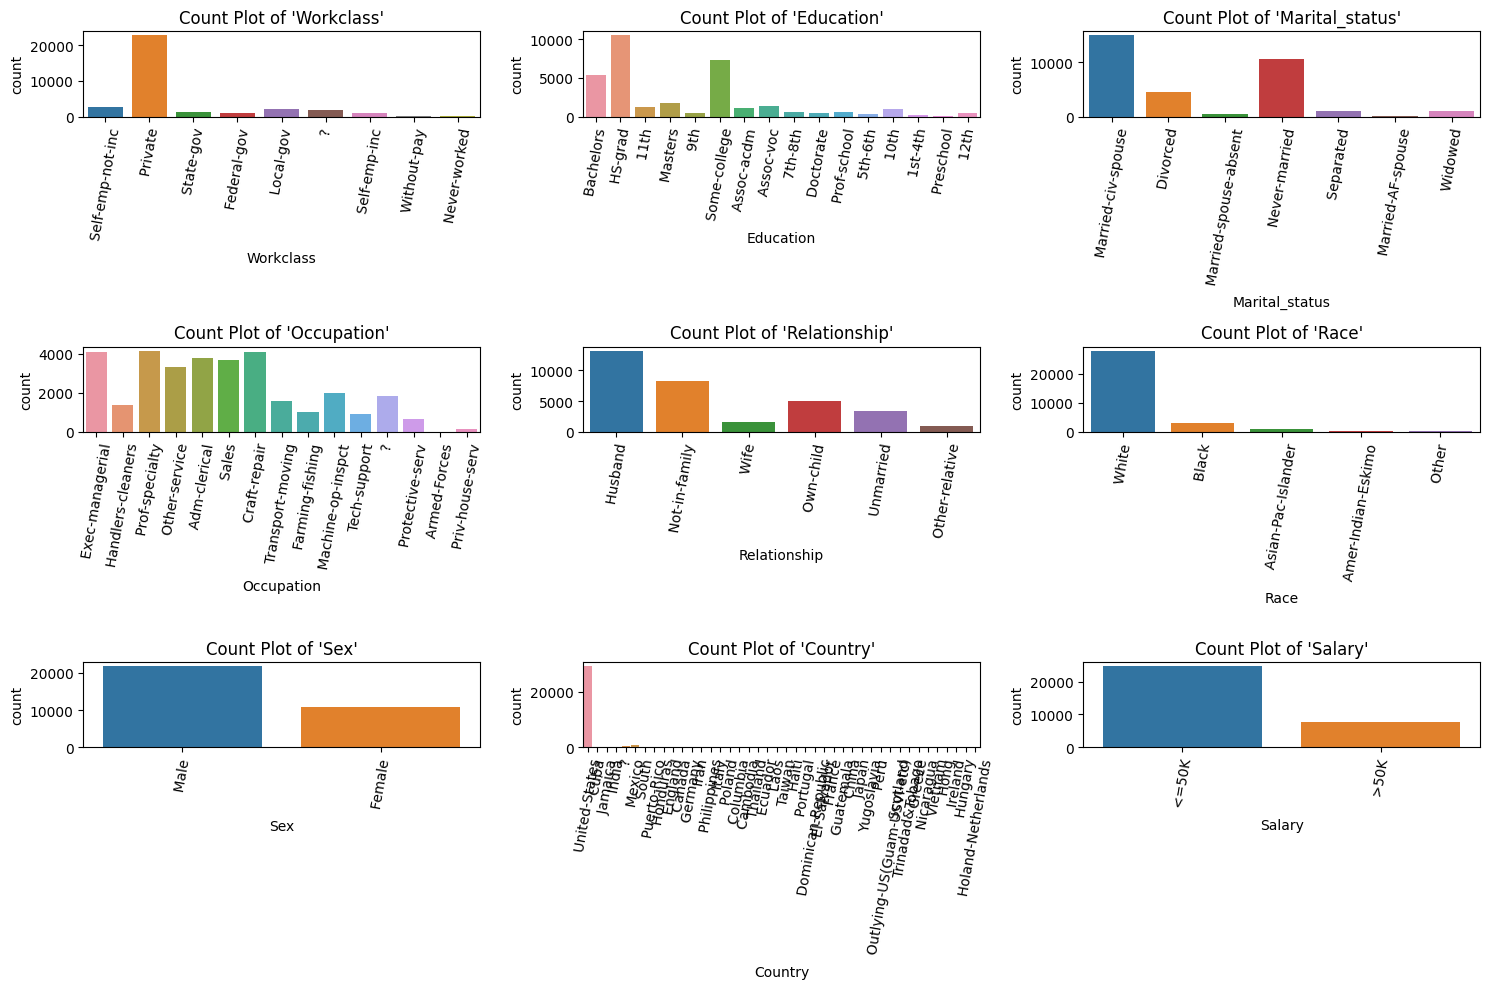

In [10]:
plot_counts(
    data=cat_data, features=cat_data.columns, n_rows=3, n_cols=3, figsize=(15, 10)
)

From the visualization above, we can see that some columns have too many categories, now lets group the data in to limit the columns that one hot encoding may display.

In [11]:
data1 = data.copy()

Grouping the data of Workclass column to have lesser columns for onehotencoding

In [12]:
data1.loc[data1['Workclass'].str.contains('State-gov'), 'Workclass'] = 'Government'
data1.loc[data1['Workclass'].str.contains('Federal-gov'), 'Workclass'] = 'Government'
data1.loc[data1['Workclass'].str.contains('Local-gov'), 'Workclass'] = 'Government'
data1.loc[data1['Workclass'].str.contains('Self-emp-inc'), 'Workclass'] = 'Self employed'
data1.loc[data1['Workclass'].str.contains('Self-emp-not-inc'), 'Workclass'] = 'Self employed'
data1.loc[data1['Workclass'].str.contains('Without-pay'), 'Workclass'] = 'Others'
data1.loc[data1['Workclass'].str.contains('Never-worked'), 'Workclass'] = 'Others'
data1['Workclass'] = data1['Workclass'].apply(lambda x: 'Others' if '?' in x else x) #Lambda will apply others to any row with ? value
data1['Workclass'].unique()

array(['Self employed', ' Private', 'Government', 'Others'], dtype=object)

Grouping the data of Education column

In [13]:
data1.loc[data1['Education'].str.contains('Bachelors'), 'Education']='Tertiary'
data1.loc[data1['Education'].str.contains('HS-grad'), 'Education']='Secondary'
data1.loc[data1['Education'].str.contains('Masters'), 'Education']='Tertiary'
data1.loc[data1['Education'].str.contains('9th'), 'Education']='Secondary'
data1.loc[data1['Education'].str.contains('Some-college'), 'Education'] = 'Tertiary'
data1.loc[data1['Education'].str.contains('11th'), 'Education']='Secondary'
data1.loc[data1['Education'].str.contains('7th-8th'), 'Education']='Secondary'
data1.loc[data1['Education'].str.contains('Doctorate'), 'Education']='Tertiary'
data1.loc[data1['Education'].str.contains('Prof-school'), 'Education']='Tertiary'
data1.loc[data1['Education'].str.contains('5th-6th'), 'Education']='Primary'
data1.loc[data1['Education'].str.contains('10th'), 'Education']='Secondary'
data1.loc[data1['Education'].str.contains('1st-4th'), 'Education']='Primary'
data1.loc[data1['Education'].str.contains('Preschool'), 'Education']='Primary'
data1.loc[data1['Education'].str.contains('12th'), 'Education'] = 'Secondary'
data1.loc[data1['Education'].str.contains('Assoc-acdm'), 'Education']='Tertiary'
data1.loc[data1['Education'].str.contains('Assoc-voc'), 'Education']='Tertiary'
data1['Education'].unique()

array(['Tertiary', 'Secondary', 'Primary'], dtype=object)

In [14]:
data1.loc[data1['Marital_status'].str.contains('Married-spouse-absent'), 'Marital_status']='Others'
data1.loc[data1['Marital_status'].str.contains( 'Seperated'), 'Marital_status']='Others'
data1.loc[data1['Marital_status'].str.contains( 'Widowed'), 'Marital_status']='Others'
data1.loc[data1['Marital_status'].str.contains( 'Married-AF-spouse'), 'Marital_status']='Others'
data1['Marital_status'].unique()

array([' Married-civ-spouse', ' Divorced', 'Others', ' Never-married',
       ' Separated'], dtype=object)

In [15]:
data1.loc[data1['Race'].str.contains('Asian-Pac-Islander'), 'Race']='Others'
data1.loc[data1['Race'].str.contains('Amer-Indian-Eskimo'), 'Race']='Others'
data1.loc[data1['Race'].str.contains('Other'), 'Race']='Others'
data1['Race'].unique()

array([' White', ' Black', 'Others'], dtype=object)

Lets drop data that are irrelevant to the features

In [16]:
data1.drop(['Occupation', 'Relationship'], axis=1) #these are the features to drop in the categorical variable according to

,Age,Workclass,Final_weight,Education,Education_num,Marital_status,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Country,Salary
0,50,Self employed,83311,Tertiary,13,Married-civ-spouse,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,Secondary,9,Divorced,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,Secondary,7,Married-civ-spouse,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Tertiary,13,Married-civ-spouse,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Tertiary,14,Married-civ-spouse,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Tertiary,12,Married-civ-spouse,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,Secondary,9,Married-civ-spouse,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,Secondary,9,Others,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,Secondary,9,Never-married,White,Male,0,0,20,United-States,<=50K


In [17]:
num_data.head()

,Age,Final_weight,Education_num,Capital_gain,Capital_loss,Hours_per_week
0,50,83311,13,0,0,13
1,38,215646,9,0,0,40
2,53,234721,7,0,0,40
3,28,338409,13,0,0,40
4,37,284582,14,0,0,40


Now lets visualize our numerical data to detect for outliers

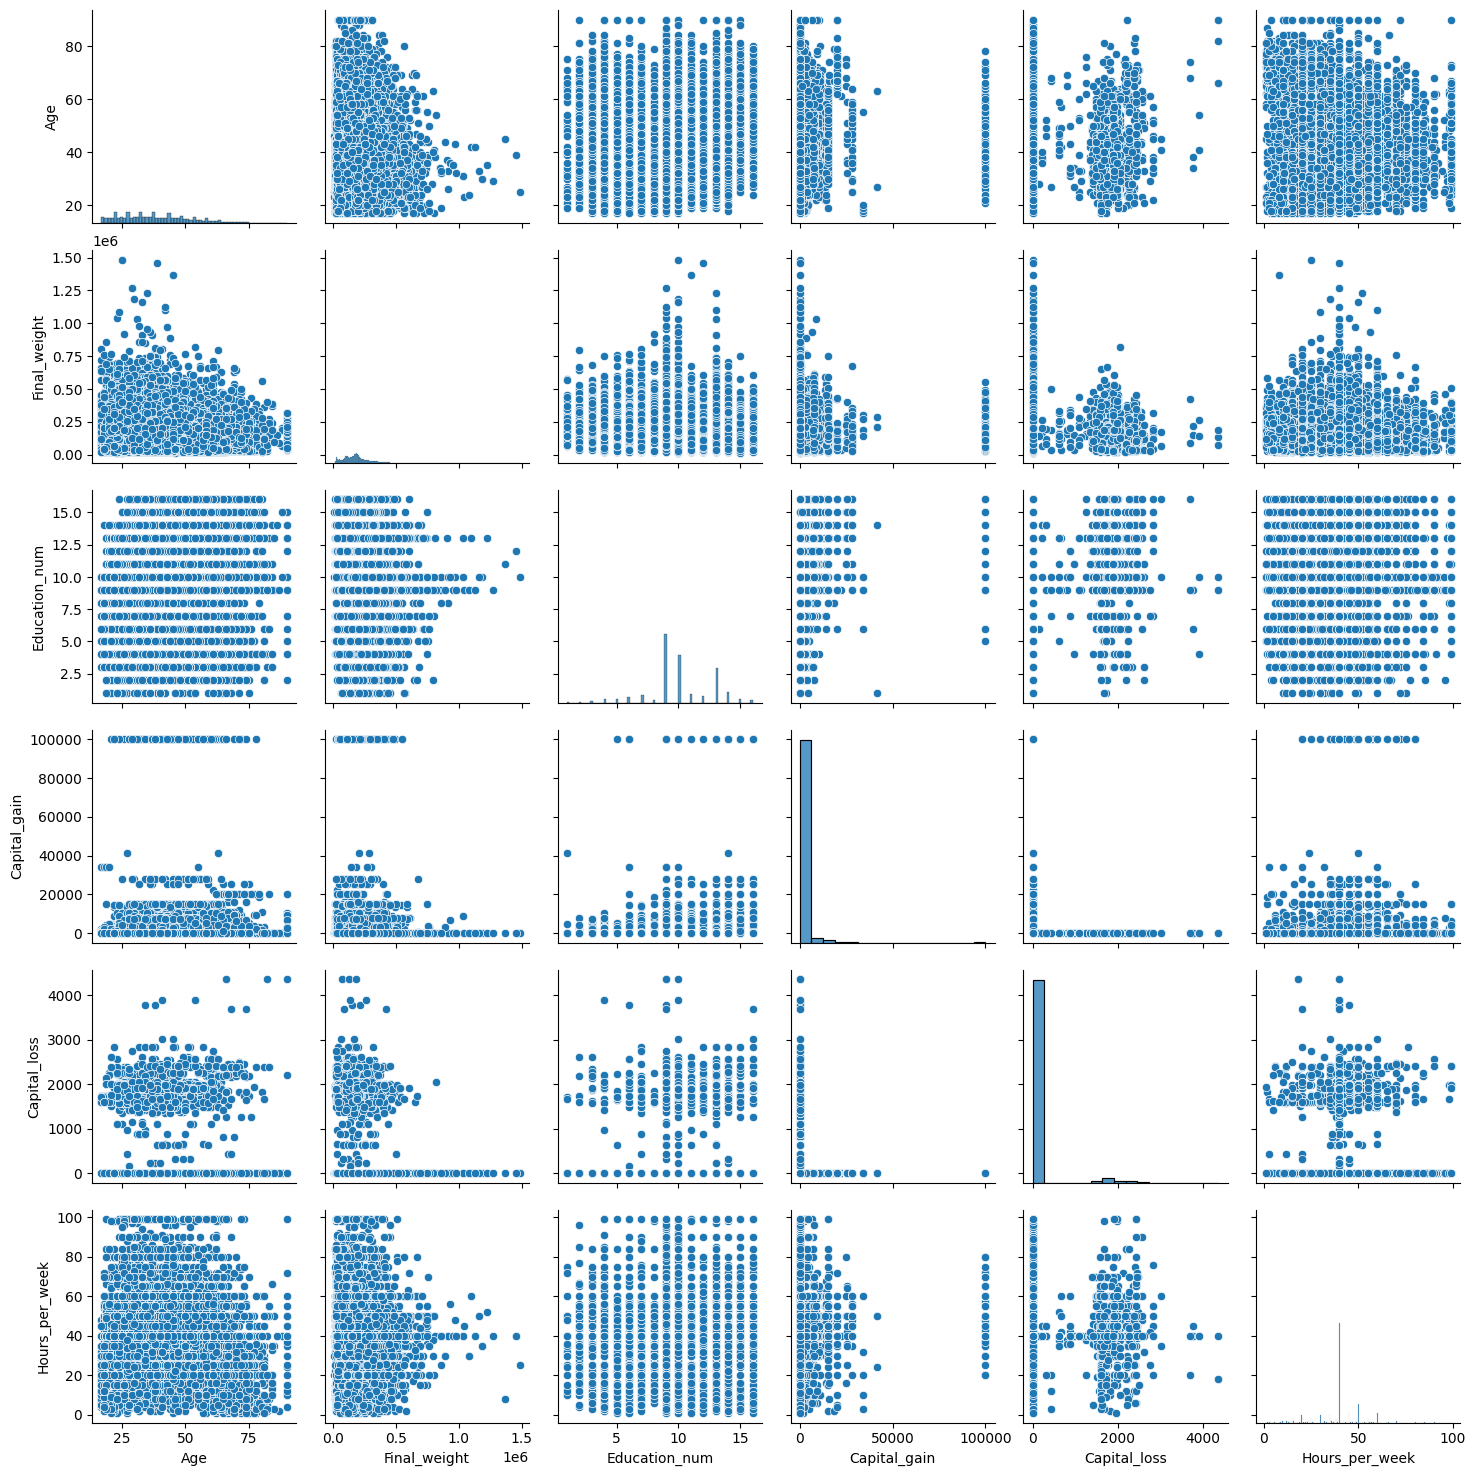

In [18]:
sns.pairplot(num_data,vars=['Age','Final_weight','Education_num','Capital_gain','Capital_loss','Hours_per_week'])
plt.show()

 Remarks:
 
 - Age: This has a few old people in the distrbution that displays outliers of a few persons around age 70-80 compared to the number of persons around age 17-60
 - Final_weights: We can see a correlation here with Age, the higher the age the lower the Final_weights for older people, hence there is a negative relationship between Age and this variable
 - Education_num: This looks okay
 - Capital_gain: This has a very huge outlier that we might drop
 - Capital_loss: This also has a very huge outlier
 - Hours_per_week

In [19]:
data1["Hours_per_week"] = pd.qcut(x=data1["Hours_per_week"],q=3,labels=False,duplicates="drop")
data1[f"Hours_per_week"].value_counts()

Hours_per_week
0    22979
1     9581
Name: count, dtype: int64

In [20]:
data1["Education_num"] = pd.qcut(x=data1["Education_num"],q=3,labels=False, duplicates='drop')
data1["Education_num"].value_counts()

Education_num
0    14754
2    10515
1     7291
Name: count, dtype: int64

In [21]:
labels= ['Young', 'Semi-young', 'Old']
data1["Age"] = pd.qcut(x=data1["Age"],q=3,labels=labels,duplicates="drop")
data1["Age"].value_counts()

Age
Young         11460
Semi-young    10739
Old           10361
Name: count, dtype: int64

In [22]:
feat = "Capital_loss"
condalist =[(data1[feat] == 0),(data1[feat] > 0)]
choicelist = ["No Loss","Loss"]
data1[feat]=np.select(condlist=condalist,choicelist=choicelist)
data1[feat].value_counts()

Capital_loss
No Loss    31041
Loss        1519
Name: count, dtype: int64

In [23]:
feat = "Capital_gain"
condalist =[(data[feat] == 0),(data[feat] > 0)]
choicelist = ["No gain","Gain"]
data1[feat]=np.select(condlist=condalist,choicelist=choicelist)
data1[feat].value_counts()

Capital_gain
No gain    29849
Gain        2711
Name: count, dtype: int64

# Machine Learning Model

In [24]:
data1.head()

,Age,Workclass,Final_weight,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Country,Salary
0,Old,Self employed,83311,Tertiary,2,Married-civ-spouse,Exec-managerial,Husband,White,Male,No gain,No Loss,0,United-States,<=50K
1,Semi-young,Private,215646,Secondary,0,Divorced,Handlers-cleaners,Not-in-family,White,Male,No gain,No Loss,0,United-States,<=50K
2,Old,Private,234721,Secondary,0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,No gain,No Loss,0,United-States,<=50K
3,Young,Private,338409,Tertiary,2,Married-civ-spouse,Prof-specialty,Wife,Black,Female,No gain,No Loss,0,Cuba,<=50K
4,Semi-young,Private,284582,Tertiary,2,Married-civ-spouse,Exec-managerial,Wife,White,Female,No gain,No Loss,0,United-States,<=50K


In [25]:
# label_encoder object knows how to understand word labels.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
data1['Salary']= label_encoder.fit_transform(data1['Salary'])
  
data1['Salary'].unique()

array([0, 1])

In [26]:

features = ['Age','Workclass','Education','Marital_status','Race', 'Sex','Capital_gain','Capital_loss','Country','Relationship']
for columns in features:
    label_encoder = preprocessing.LabelEncoder()
    data1[columns] = label_encoder.fit_transform(data1[columns])

In [27]:
data1.head() #to view our encoded variables

,Age,Workclass,Final_weight,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Country,Salary
0,0,3,83311,2,2,1,Exec-managerial,0,1,1,1,1,0,39,0
1,1,0,215646,1,0,0,Handlers-cleaners,1,1,1,1,1,0,39,0
2,0,0,234721,1,0,1,Handlers-cleaners,0,0,1,1,1,0,39,0
3,2,0,338409,2,2,1,Prof-specialty,5,0,0,1,1,0,5,0
4,1,0,284582,2,2,1,Exec-managerial,5,1,0,1,1,0,39,0


In [28]:
#Lets split our data

In [29]:
TEST_SIZE = 0.2
RANDOM_STATE = 400
X = data1.drop(['Salary', 'Occupation'], axis=1)
y = data1['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [30]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
y_pred = model.predict(X_test)

# Evaluating the performance of the model using 4 metrics

Because this is a classification, we will be using confusion matrix and accuracy score to evaluate the performance of our model

In [36]:
from sklearn import metrics

In [40]:
y_test_pred = model.predict(X_test) #predicting the target vector

In [ ]:
#Evaluating model
metrics.roc_auc_score(y_true=temp[TARGET], y_score=temp["Sex"])

In [41]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred) 
print("confusion matrix:\n", cf_matrix)

confusion matrix:
 [[4358  594]
 [ 729  831]]


In [44]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

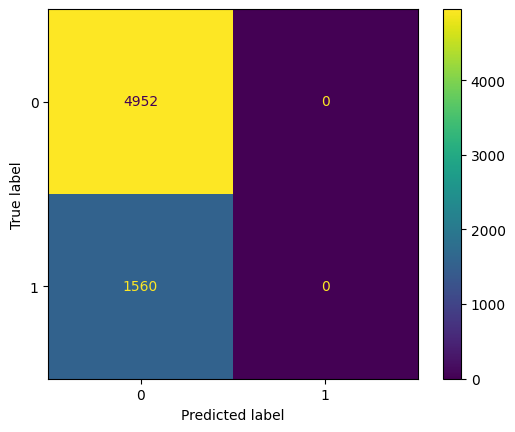

In [47]:
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [48]:
print('Test Accuracy: %.3f' % metrics.accuracy_score(y_test, y_pred))

Test Accuracy: 0.797
